In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
import collections
from itertools import count
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T


from pybullet_envs.bullet.kuka_diverse_object_gym_env import KukaDiverseObjectEnv
import pybullet as p

env = KukaDiverseObjectEnv(renders=True, isDiscrete=True, removeHeightHack=False, maxSteps=20,isTest=True,numObjects=5)

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

pybullet build time: Apr 30 2024 16:13:20


current_dir=/Users/ishankharat/anaconda3/envs/m3detr/lib/python3.10/site-packages/pybullet_envs/bullet
Version = 4.1 Metal - 88
Vendor = Apple
Renderer = Apple M1
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
cpu


In [3]:
STACK_SIZE = 5

In [4]:
class DQN(nn.Module):
    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()  
        self.conv1 = nn.Conv2d(STACK_SIZE, 32, kernel_size=8, stride=4)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)

        # Number of Linear input connections depends on output of conv2d layers
        # and therefore the input image size, so compute it.
        def conv2d_size_out(size, kernel_size = 5, stride = 2):
            return (size - (kernel_size - 1) - 1) // stride  + 1
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w,8,4),4,2),3,1)
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h,8,4),4,2),3,1)
        linear_input_size = convw * convh * 64
        self.linear = nn.Linear(linear_input_size, 512)
        self.head = nn.Linear(512, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = F.relu(self.linear(x.view(x.size(0), -1)))
        return self.head(x)

## Input extraction


The code below are utilities for extracting and processing rendered
images from the environment. It uses the ``torchvision`` package, which
makes it easy to compose image transforms. Once you run the cell it will
display an example patch that it extracted.




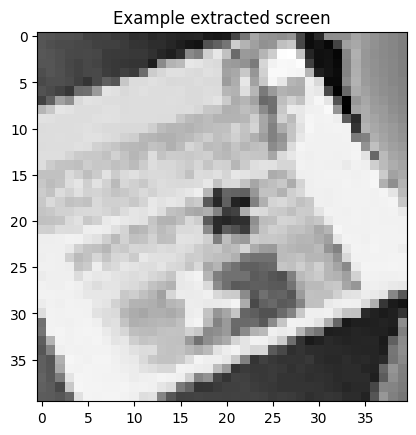

In [5]:
preprocess = T.Compose([T.ToPILImage(),
                    T.Grayscale(num_output_channels=1),
                    T.Resize(40, interpolation=Image.BICUBIC),
                    T.ToTensor()])

def get_screen():
    global stacked_screens
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env._get_observation().transpose((2, 0, 1))
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return preprocess(screen).unsqueeze(0).to(device)


env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0)[-1].numpy(),cmap='Greys',
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

In [6]:
# Get screen size so that we can initialize layers correctly based on shape
# returned from pybullet (48, 48, 3).  
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

# Get number of actions from gym action space
n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
checkpoint = torch.load('policy_dqn.pt')
policy_net.load_state_dict(checkpoint['policy_net_state_dict'])
target_net.load_state_dict(checkpoint['target_net_state_dict'])
# target_net.load_state_dict(policy_net.state_dict())
target_net.eval()
episode = 10

# load the model
checkpoint = torch.load('policy_dqn.pt')
policy_net.load_state_dict(checkpoint['policy_net_state_dict'])
reward_list = []
# evaluate the model
for i_episode in range(episode):
    env.reset()
    state = get_screen()
    stacked_states = collections.deque(STACK_SIZE*[state],maxlen=STACK_SIZE)
    for t in count():
        stacked_states_t =  torch.cat(tuple(stacked_states),dim=1)
        # Select and perform an action
        action = policy_net(stacked_states_t).max(1)[1].view(1, 1)
        _, reward, done, _ = env.step(action.item())
        reward_list.append(reward)
        # Observe new state
        next_state = get_screen()
        stacked_states.append(next_state)
        if done:
            break
    print("Episode: {0:d}, reward: {1}".format(i_episode+1, reward), end="\n")

env.close()
fig = plt.figure()
plt.plot(np.arange(len(reward_list)), reward_list)
plt.ylabel('Score')
plt.xlabel('Season #')
plt.grid()
plt.show()